# Bicycle Crashes
- Town of Chapel Hill, North Carolina 

In [1]:
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import seaborn as sns
import sys

%matplotlib inline
    
# df = pd.read_csv('https://catalog.data.gov/dataset/bicycle-crashes.csv')
fname = 'https://www.chapelhillopendata.org/api/v2/catalog/datasets/bicycle-crash-data-chapel-hill-region/exports/csv'
df = pd.read_csv(fname, sep=';')
df

,geo_point_2d,geo_shape,ambulancer,bikeage_gr,bike_age,bike_dir,bike_injur,bike_pos,bike_race,bike_sex,...,rd_conditi,rd_config,rd_defects,rd_feature,rd_surface,rural_urba,speed_limi,traff_cntr,weather,workzone_i
0,"35.9100670923, -79.0745027481","{""type"": ""Point"", ""coordinates"": [-79.07450274...",Yes,70+,70+,With Traffic,K: Killed,Travel Lane,White,Male,...,Dry,"Two-Way, Not Divided",None,No Special Feature,Smooth Asphalt,Urban,20 - 25 MPH,No Control Present,Clear,No
1,"36.0151171157, -79.0306027406","{""type"": ""Point"", ""coordinates"": [-79.03060274...",No,20-24,24,With Traffic,C: Possible Injury,Travel Lane,White,Male,...,Dry,"Two-Way, Not Divided",None,"Driveway, Private",Coarse Asphalt,Rural,40 - 45 MPH,"Double Yellow Line, No Passing Zone",Clear,No
2,"35.9889631116, -78.9887827261","{""type"": ""Point"", ""coordinates"": [-78.98878272...",Yes,25-29,26,With Traffic,B: Evident Injury,Travel Lane,Black,Male,...,Dry,"Two-Way, Not Divided",None,No Special Feature,Smooth Asphalt,Urban,40 - 45 MPH,"Double Yellow Line, No Passing Zone",Clear,No
3,"35.9227900944, -79.0888327525","{""type"": ""Point"", ""coordinates"": [-79.08883275...",Yes,30-39,33,With Traffic,B: Evident Injury,Travel Lane,White,Female,...,Dry,"Two-Way, Not Divided",None,T-Intersection,Smooth Asphalt,Urban,30 - 35 MPH,Missing,Clear,No
4,"36.0100771166, -78.9900027276","{""type"": ""Point"", ""coordinates"": [-78.99000272...",Yes,40-49,41,With Traffic,B: Evident Injury,Travel Lane,White,Female,...,Dry,"Two-Way, Not Divided",None,Four-Way Intersection,Smooth Asphalt,Rural,40 - 45 MPH,Stop Sign,Clear,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160,"35.9382390969, -79.1048027585","{""type"": ""Point"", ""coordinates"": [-79.10480275...",Yes,20-24,21,With Traffic,C: Possible Injury,Travel Lane,White,Male,...,Dry,"Two-Way, Not Divided",None,No Special Feature,Smooth Asphalt,Rural,40 - 45 MPH,No Control Present,Clear,No
161,"35.9376070989, -79.0565827433","{""type"": ""Point"", ""coordinates"": [-79.05658274...",Yes,60-69,65,With Traffic,A: Disabling Injury,Travel Lane,White,Male,...,Dry,"Two-Way, Not Divided",None,No Special Feature,Smooth Asphalt,Urban,30 - 35 MPH,No Control Present,Clear,No
162,"35.9090970918, -79.0778687486","{""type"": ""Point"", ""coordinates"": [-79.07786874...",No,30-39,36,With Traffic,B: Evident Injury,Unknown,White,Male,...,Dry,"Two-Way, Not Divided",None,T-Intersection,Smooth Asphalt,Urban,30 - 35 MPH,No Control Present,Clear,No
163,"35.9152570935, -79.0568027425","{""type"": ""Point"", ""coordinates"": [-79.05680274...",Yes,30-39,38,With Traffic,B: Evident Injury,Travel Lane,White,Male,...,Dry,"Two-Way, Divided, Unprotected Median",None,Other,Smooth Asphalt,Urban,20 - 25 MPH,Stop Sign,Clear,No


In [2]:
df.columns

Index(['geo_point_2d', 'geo_shape', 'ambulancer', 'bikeage_gr', 'bike_age',
       'bike_dir', 'bike_injur', 'bike_pos', 'bike_race', 'bike_sex', 'city',
       'county', 'crashalcoh', 'crashday', 'crash_grp', 'crash_loc',
       'crash_mont', 'crash_time', 'crash_type', 'crash_year', 'crsh_sevri',
       'developmen', 'drvrage_gr', 'drvr_age', 'drvr_alc_d', 'drvr_estsp',
       'drvr_injur', 'drvr_race', 'drvr_sex', 'drvr_vehty', 'excsspdind',
       'hit_run', 'light_cond', 'locality', 'num_lanes', 'num_units',
       'rd_charact', 'rd_class', 'rd_conditi', 'rd_config', 'rd_defects',
       'rd_feature', 'rd_surface', 'rural_urba', 'speed_limi', 'traff_cntr',
       'weather', 'workzone_i'],
      dtype='object')

## Data Preperation

### Utility function to test if a dataframe contains any NaNs

In [3]:
def testDataFrameForNulls(df):
    '''Test to see if the dataframe contains NaNs
       @raise If there are NaNs in the dataframe
    '''
    if 0 != df.isna().values.sum():
        raise Exception("Dataframe contains NaNs")


### Utility function to translate a speed_limit of form "25 - 35 MPH" to (25, 35)

In [4]:
def translateSpeed(loc, x):
    ''' Translate a speed of the format "25 - 35 MPH" to (25, 35)'''


    m = re.findall(r'^(\d+)\s*-\s*(\d+)\s*MPH$', x)
    if m:
        m = (np.uint32(m[0][0]), np.uint32(m[0][1]))
    else:
        m = (0,0)

    #print("translateSpeed({}, {}) = {}".format(loc, x, m))
    return m



### Create a MultiIndex from a dot-product given a list of two lists

indices = pd.MultiIndex.from_product(
    [['Alice','Bob','Charlie','Dave'], ['cs1', 'cs2']],
    names=['Student', 'Class'])

In [5]:
def DrawVeriticalLinePlots(bike_sex_dict):
    # palette choices deep, muted, bright, pastel, dark, colorblind
    palette = sns.color_palette(palette='bright', n_colors=None, desat=None)

    fig, ax = plt.subplots(len(bike_sex_dict), 1, figsize=(20, 20))
    #plt.subplots_adjust(hspace = 0.5, top=5)

    for bike_sex_index, bike_sex in enumerate(bike_sex_dict):
        # Initialze the variables used for plotting the lines
        x_limit_max = 0
        y_limit_max = 0
        x_values = []
        y_values_min = []
        y_values_max = []
        colors=[]
        labels=[]
        
        bike_sex_df = bike_sex_dict[bike_sex]

        for injury_index, injury_name in enumerate(bike_sex_df.index):
            # Update the colors & labels
            colors.append(palette[injury_index % len(palette)])
            labels.append(injury_name)
            
            injury = bike_sex_df[bike_sex_df.index.get_level_values('bike_injur').isin([injury_name])]
            injury.unstack()
            speeds = injury.values[0][0]

            # Update the x_limit_max
            if x_limit_max < len(speeds):
                x_limit_max = len(speeds) + 1

            # UPdate the x_values, y_values_min, y_values_max, & y_limit_max
            for speed_index, speed in enumerate(speeds):
                y_min = speed[0]
                y_max = speed[1]

                x_values.append(speed_index+1)
                y_values_min.append(y_min)
                y_values_max.append(y_max)
                if y_limit_max < y_max:
                    y_limit_max = y_max
            
        legend_lines = []
        for c in colors:
            legend_lines.append(Line2D([0], [0], color=c, lw=2))

        ax[bike_sex_index].set_xlim([0, x_limit_max]) 
        ax[bike_sex_index].set_ylim([0, y_limit_max]) 
        ax[bike_sex_index].vlines(x=x_values, ymin = y_values_min, ymax=y_values_max, colors = colors, label=labels)
        ax[bike_sex_index].set_title(bike_sex)
        ax[bike_sex_index].set_xlabel("x")
        ax[bike_sex_index].set_ylabel("speed_range");
        ax[bike_sex_index].legend(legend_lines, labels, shadow=True, fancybox=True)


In [6]:
try:
    testDataFrameForNulls(df)

    # Create a dataframe with the following format:
    #                                                                     speed_limit
    # bike_injur          bike_sex                                                   
    # A: Disabling Injury Female                                           [(50, 55)]
    #                     Male               [(40, 45), (30, 35), (40, 45), (30, 35)]
    # B: Evident Injury   Female    [(30, 35), (40, 45), (20, 25), (20, 25), (20, ...
    #                     Male      [(40, 45), (20, 25), (20, 25), (20, 25), (20, ...
    # C: Possible Injury  Female    [(20, 25), (20, 25), (5, 15), (20, 25), (40, 4...
    #                     Male      [(40, 45), (30, 35), (0, 0), (30, 35), (30, 35...
    # K: Killed           Male                         [(20, 25), (50, 55), (40, 45)]
    # O: No Injury        Female                                           [(30, 35)]
    #                     Male      [(30, 35), (20, 25), (20, 25), (20, 25), (40, ...
    # Unknown Injury      Male                                   [(20, 25), (20, 25)]
    #                     Unknown                                          [(30, 35)]
    df['speed_limit'] = [translateSpeed(i, x) for i, x in enumerate(df['speed_limi'])]

    #a = df[(df['bike_injur'] == 'A: Disabling Injury') & (df['bike_sex'] == 'Female')]
    #b = df[(df['bike_injur'] == 'A: Disabling Injury') & (df['bike_sex'] == 'Male')]
    bike_injur_sex = df.groupby(['bike_injur', 'bike_sex'])
    bike_injur_sex = bike_injur_sex['speed_limit'].apply(list).to_frame()
    
    # Now create the dictionary of dataframes based on the bike_sex of the following format:
    # ----------------------------
    # key=Female:
    # 
    #                                                            speed_limit
    # bike_injur                                                            
    # A: Disabling Injury                                         [(50, 55)]
    # B: Evident Injury    [(30, 35), (40, 45), (20, 25), (20, 25), (20, ...
    # C: Possible Injury   [(20, 25), (20, 25), (5, 15), (20, 25), (40, 4...
    # O: No Injury                                                [(30, 35)]
    # 
    # ----------------------------
    # key=Male:
    # 
    #                                                            speed_limit
    # bike_injur                                                            
    # A: Disabling Injury           [(40, 45), (30, 35), (40, 45), (30, 35)]
    # B: Evident Injury    [(40, 45), (20, 25), (20, 25), (20, 25), (20, ...
    # C: Possible Injury   [(40, 45), (30, 35), (0, 0), (30, 35), (30, 35...
    # K: Killed                               [(20, 25), (50, 55), (40, 45)]
    # O: No Injury         [(30, 35), (20, 25), (20, 25), (20, 25), (40, ...
    # Unknown Injury                                    [(20, 25), (20, 25)]
    # 
    # ----------------------------
    # key=Unknown:
    # 
    #                speed_limit
    # bike_injur                
    # Unknown Injury  [(30, 35)]

    bike_sex_dict = {}
    bike_sex_values = bike_injur_sex.index.get_level_values('bike_sex').unique()
    for bike_sex in bike_sex_values:
        bike_sex_dict[bike_sex] = bike_injur_sex[
            bike_injur_sex.index.get_level_values('bike_sex').isin([bike_sex])].droplevel('bike_sex')

    #DrawVeriticalLinePlots(bike_sex_dict)
    #for bike_sex_index in bike_sex_dict:
    #    sns.catplot(
    #        x=bike_sex_dict[bike_sex_index].index,
    #        y=bike_sex_dict[bike_sex_index]['speed_limit'].values[0], 
    #        ind="swarm",
    #        data=bike_sex_dict[bike_sex_index]);


except Exception as e:
        raise type(e)(str(e)).with_traceback(sys.exc_info()[2])

<class 'numpy.ndarray'>


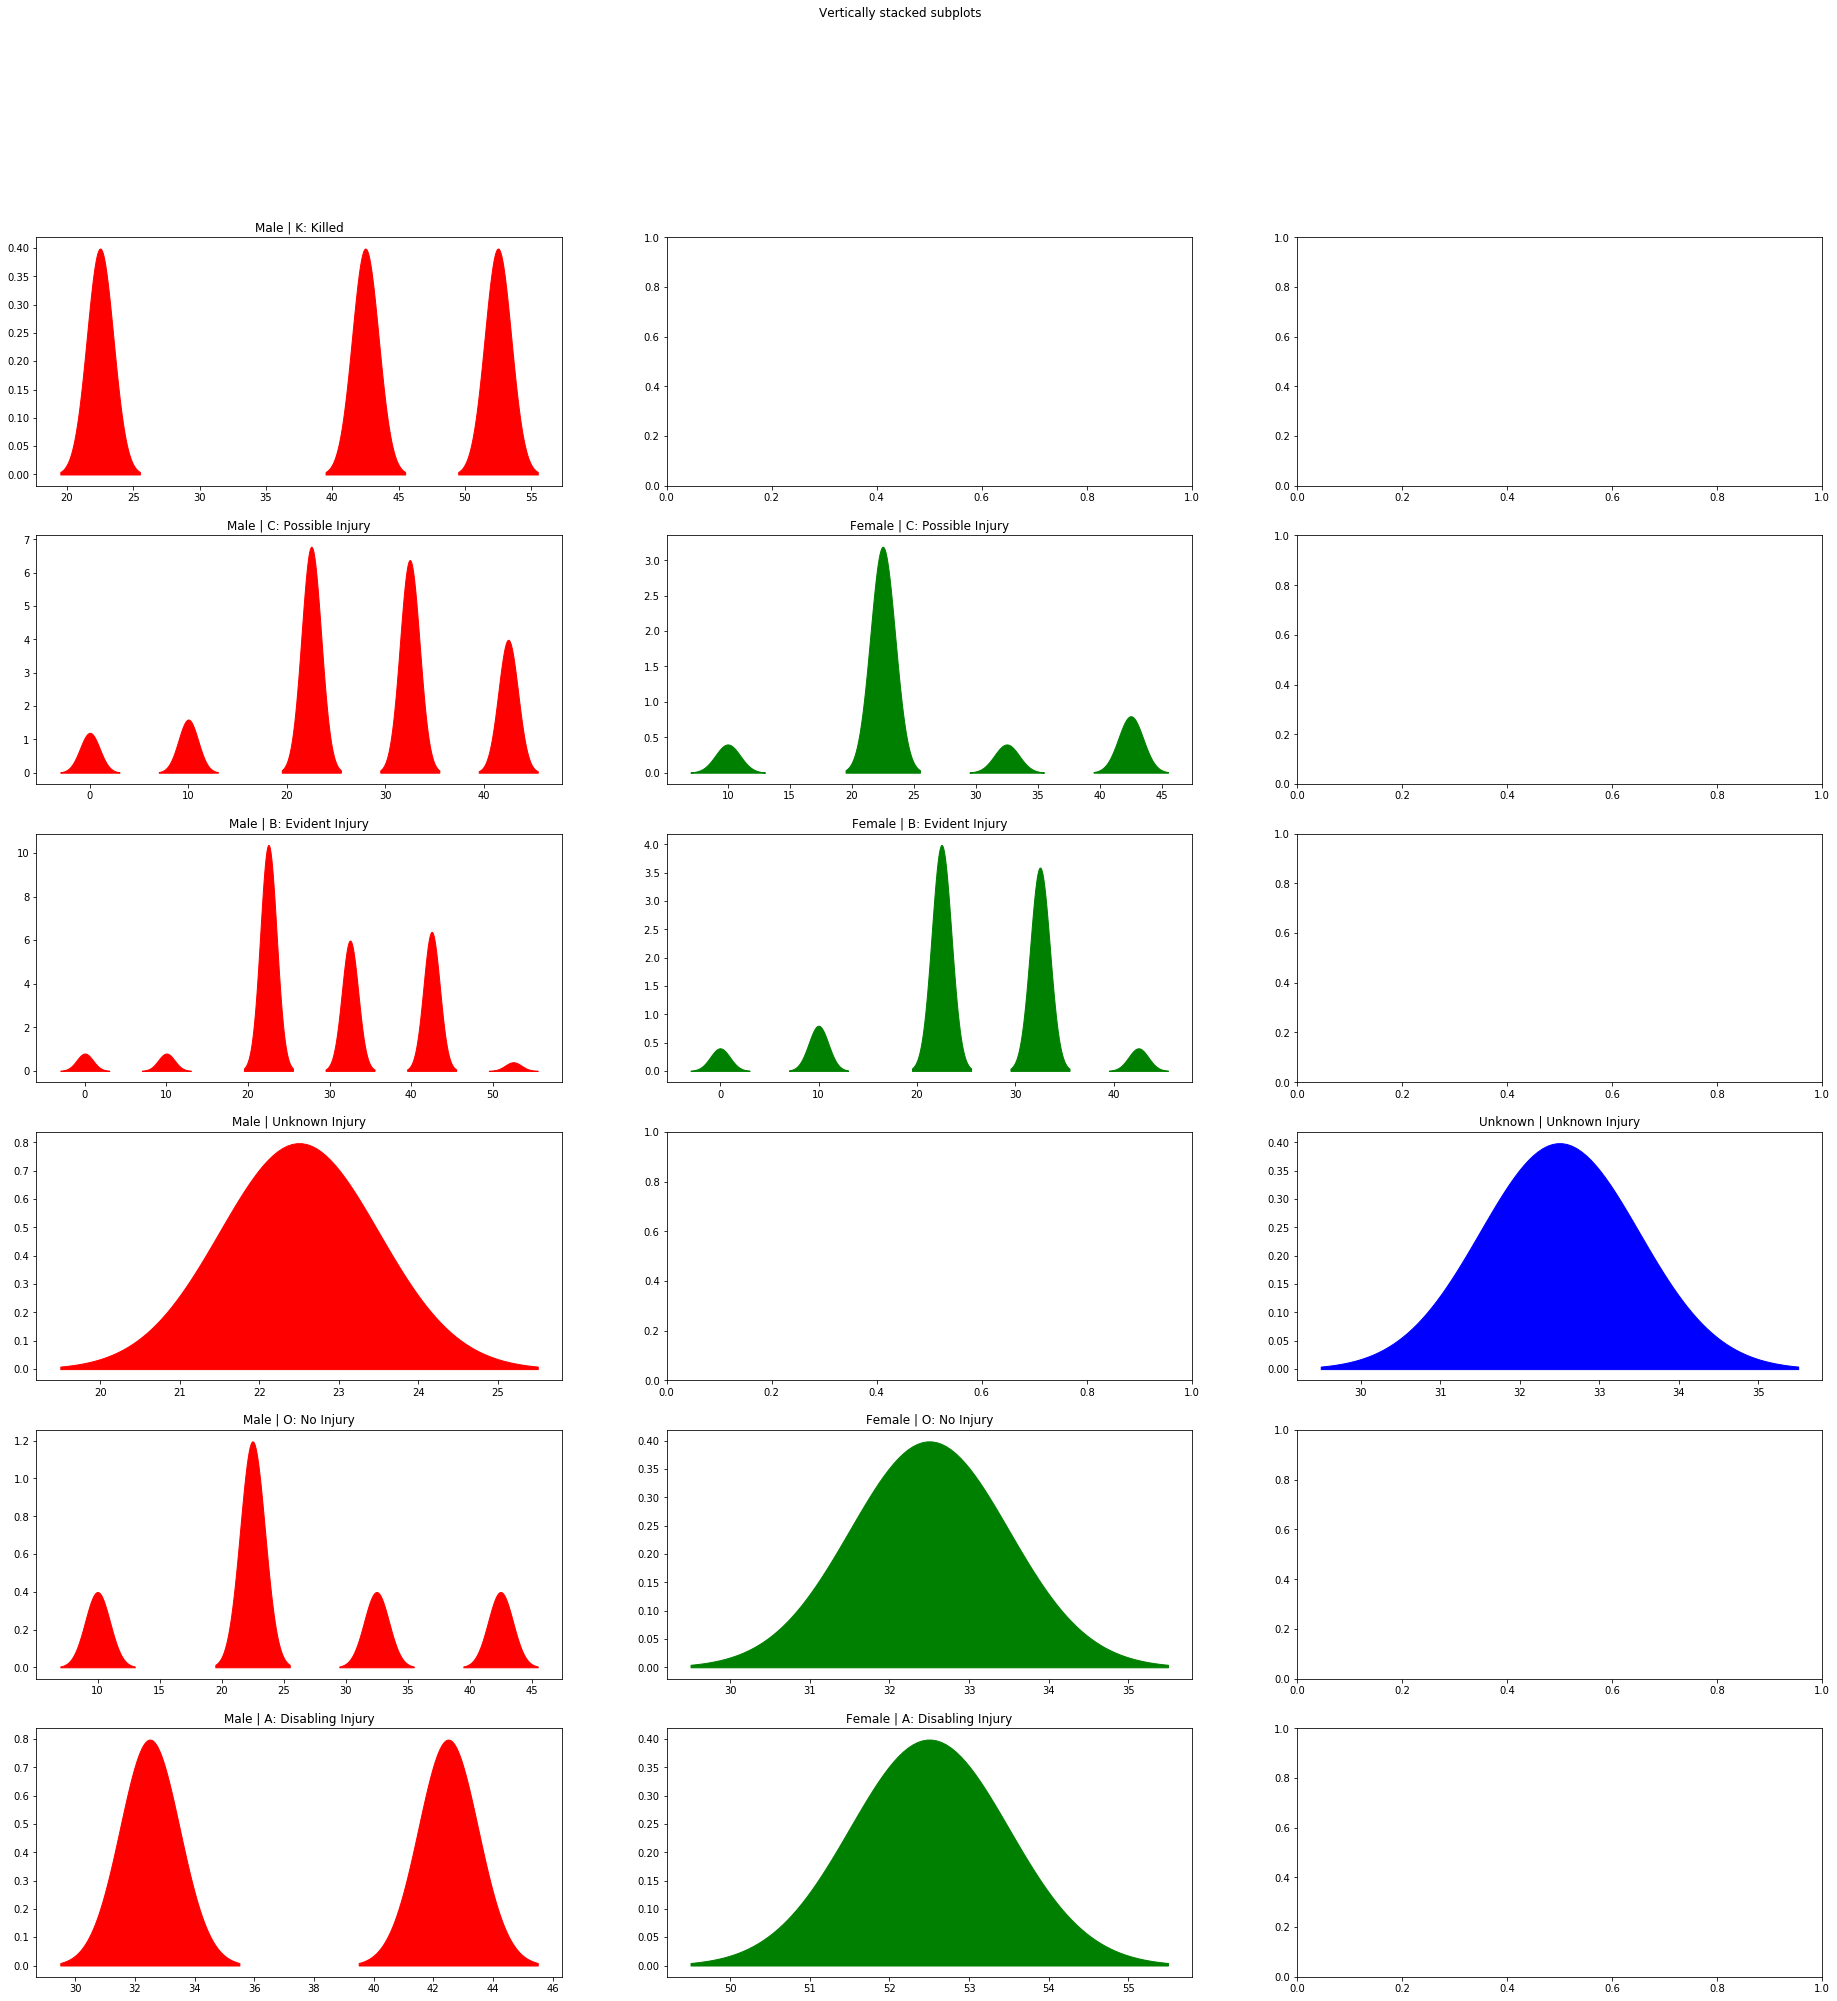

In [144]:

def getListOfPoints(_min, _max):
    l = []
    if (_min != 0) and (_max != 0):
        l = list(range(_min, _max))
    return l

def getSpeeds(speed_list):
    points = []
    [points.extend(getListOfPoints(_min, _max)) for _min, _max in speed_list]
    return points

def CountFrequency(my_list): 
    # Creating an empty dictionary  
    freq = {} 
    for item in my_list: 
        if item in freq: 
            freq[item] += 1
        else: 
            freq[item] = 1
    return freq

try:
    # Create a dataframe of the format:
    #                                                                 speed_limit
    # bike_injur          bike_sex                                                   
    # A: Disabling Injury Female                                           [(50, 55)]
    #                     Male               [(40, 45), (30, 35), (40, 45), (30, 35)]
    # B: Evident Injury   Female    [(30, 35), (40, 45), (20, 25), (20, 25), (20, ...
    #                     Male      [(40, 45), (20, 25), (20, 25), (20, 25), (20, ...
    # C: Possible Injury  Female    [(20, 25), (20, 25), (5, 15), (20, 25), (40, 4...
    #                     Male      [(40, 45), (30, 35), (0, 0), (30, 35), (30, 35...
    # K: Killed           Male                         [(20, 25), (50, 55), (40, 45)]
    # O: No Injury        Female                                           [(30, 35)]
    #                     Male      [(30, 35), (20, 25), (20, 25), (20, 25), (40, ...
    # Unknown Injury      Male                                   [(20, 25), (20, 25)]
    #                     Unknown                                          [(30, 35)]
    bike_injur_sex = df.groupby(['bike_injur', 'bike_sex'])
    bike_injur_sex = bike_injur_sex['speed_limit'].apply(list).to_frame()
    #print(bike_injur_sex)

    # Create dot product index as shown below:
    # MultiIndex([(          'K: Killed',    'Male'),
    #         (          'K: Killed',  'Female'),
    #         (          'K: Killed', 'Unknown'),
    #         ( 'C: Possible Injury',    'Male'),
    #         ( 'C: Possible Injury',  'Female'),
    #         ( 'C: Possible Injury', 'Unknown'),
    #         (  'B: Evident Injury',    'Male'),
    #         (  'B: Evident Injury',  'Female'),
    #         (  'B: Evident Injury', 'Unknown'),
    #         (     'Unknown Injury',    'Male'),
    #         (     'Unknown Injury',  'Female'),
    #         (     'Unknown Injury', 'Unknown'),
    #         (       'O: No Injury',    'Male'),
    #         (       'O: No Injury',  'Female'),
    #         (       'O: No Injury', 'Unknown'),
    #         ('A: Disabling Injury',    'Male'),
    #         ('A: Disabling Injury',  'Female'),
    #         ('A: Disabling Injury', 'Unknown')],
    #        names=['injuries', 'sex'])
    injuries = df['bike_injur'].unique()
    sexes = df['bike_sex'].unique()
    dot_prod_injur_sex = pd.MultiIndex.from_product([injuries, sexes], names=['injuries', 'sex'])
  
    # Create df2 of the form:
    #                 injuries     sex speed_range
    # 0              K: Killed    Male    (20, 25)
    # 1              K: Killed    Male    (50, 55)
    # 2              K: Killed    Male    (40, 45)
    # 3     C: Possible Injury    Male    (40, 45)
    # 4     C: Possible Injury    Male    (30, 35)
    # ..                   ...     ...         ...
    # 160  A: Disabling Injury    Male    (40, 45)
    # 161  A: Disabling Injury    Male    (30, 35)
    # 162  A: Disabling Injury    Male    (40, 45)
    # 163  A: Disabling Injury    Male    (30, 35)
    # 164  A: Disabling Injury  Female    (50, 55)
    # 
    # [165 rows x 5 columns]
    df2 = pd.DataFrame(columns=['injuries', 'sex', 'speed_range'])
    for index in dot_prod_injur_sex:
        try:
            for speed_range in bike_injur_sex.loc[index]['speed_limit']:
                df2 = df2.append({
                    'injuries': index[0], 'sex': index[1],
                    'speed_range': speed_range},
                    ignore_index=True)
        except KeyError:
            pass
        except Exception as e:
            print("ERROR:  Creating dictionary index=", index)
            raise Exception('Error creating dictionary index=', index)

    # Make sure the triplet ['injuries', 'sex', 'speed_range'] is unique and add the # of riders
    #                    injuries      sex speed_range  riders
    # 0   A: Disabling Injury   Female    (50, 55)       1
    # 1   A: Disabling Injury     Male    (30, 35)       2
    # 2   A: Disabling Injury     Male    (40, 45)       2
    # 3     B: Evident Injury   Female      (0, 0)       1
    # 4     B: Evident Injury   Female     (5, 15)       2
    # 5     B: Evident Injury   Female    (20, 25)      10
    # 6     B: Evident Injury   Female    (30, 35)       9
    # 7     B: Evident Injury   Female    (40, 45)       1
    # 8     B: Evident Injury     Male      (0, 0)       2
    # 9     B: Evident Injury     Male     (5, 15)       2
    # 10    B: Evident Injury     Male    (20, 25)      26
    # 11    B: Evident Injury     Male    (30, 35)      15
    # 12    B: Evident Injury     Male    (40, 45)      16
    # 13    B: Evident Injury     Male    (50, 55)       1
    # 14   C: Possible Injury   Female     (5, 15)       1
    # 15   C: Possible Injury   Female    (20, 25)       8
    # 16   C: Possible Injury   Female    (30, 35)       1
    # 17   C: Possible Injury   Female    (40, 45)       2
    # 18   C: Possible Injury     Male      (0, 0)       3
    # 19   C: Possible Injury     Male     (5, 15)       4
    # 20   C: Possible Injury     Male    (20, 25)      17
    # 21   C: Possible Injury     Male    (30, 35)      16
    # 22   C: Possible Injury     Male    (40, 45)      10
    # 23            K: Killed     Male    (20, 25)       1
    # 24            K: Killed     Male    (40, 45)       1
    # 25            K: Killed     Male    (50, 55)       1
    # 26         O: No Injury   Female    (30, 35)       1
    # 27         O: No Injury     Male     (5, 15)       1
    # 28         O: No Injury     Male    (20, 25)       3
    # 29         O: No Injury     Male    (30, 35)       1
    # 30         O: No Injury     Male    (40, 45)       1
    # 31       Unknown Injury     Male    (20, 25)       2
    # 32       Unknown Injury  Unknown    (30, 35)       1
    df2= df2.groupby(['injuries', 'sex', 'speed_range'])['speed_range'].count().reset_index(name="riders")
    #print(df2)
    
    #fig, ax = plt.subplots(figsize=(10,10))

    # Now pivot the table get the the riders being to only data column
    #                                          riders
    # injuries            sex     speed_range        
    # A: Disabling Injury Female  (50, 55)          1
    #                     Male    (30, 35)          2
    #                             (40, 45)          2
    # B: Evident Injury   Female  (0, 0)            1
    #                             (5, 15)           2
    #                             (20, 25)         10
    #                             (30, 35)          9
    #                             (40, 45)          1
    #                     Male    (0, 0)            2
    #                             (5, 15)           2
    #                             (20, 25)         26
    #                             (30, 35)         15
    #                             (40, 45)         16
    #                             (50, 55)          1
    # C: Possible Injury  Female  (5, 15)           1
    #                             (20, 25)          8
    #                             (30, 35)          1
    #                             (40, 45)          2
    #                     Male    (0, 0)            3
    #                             (5, 15)           4
    #                             (20, 25)         17
    #                             (30, 35)         16
    #                             (40, 45)         10
    # K: Killed           Male    (20, 25)          1
    #                             (40, 45)          1
    #                             (50, 55)          1
    # O: No Injury        Female  (30, 35)          1
    #                     Male    (5, 15)           1
    #                             (20, 25)          3
    #                             (30, 35)          1
    #                             (40, 45)          1
    # Unknown Injury      Male    (20, 25)          2
    #                     Unknown (30, 35)          1
    df3 = pd.pivot_table(df2,index=['injuries', 'sex', 'speed_range'])
    
    fig, axs = plt.subplots(len(injuries), len(sexes), figsize=(32,32))
    fig.suptitle('Vertically stacked subplots')
    for index in df3.index:
        (injury, sex, speed_range) = index
        riders = df3.loc[index]['riders']
        
        import scipy.stats as stats
        import math

        mu = speed_range[0] + ((speed_range[1] - speed_range[0]) / 2)
        variance = 1
        sigma = math.sqrt(variance)
        x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
        y = stats.norm.pdf(x, mu, sigma)

        i = np.where(injuries==injury)[0][0]
        s = np.where(sexes==sex)[0][0]
        axs[i, s].title.set_text('{} | {}'.format(sex, injury))
        axs[i, s].fill_between(x, 0, y * riders, color=['r', 'g', 'b'][s])
        #break
        

except Exception as e:
        raise type(e)(str(e)).with_traceback(sys.exc_info()[2])


In [103]:
%tb


ValueError: Expected the given number of height ratios to match the number of rows of the grid